## Bachelor Thesis - Informatik

### Variante 3 :
### Multiclass-Klassifizierung mit 1D Convolutional Neuronal Network
***


<div align="left">
<h2><img src="https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExZ2hrOGtveWx0ZGxsaGFsYXNzbjVhOTNyaTg2cG44anZ5eWd5a3ZyMyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/l3vRcrVqhBVSpJte0/giphy.gif" width="200" alt="Data"></h2>
</div>

Dieser Ansatz verwendet als Datengrundlage den folgenden Datensatz :

[https://github.com/michidk/myo-dataset]

###### ☑️ Der Datensatz wurde neu aufbereitet, siehe dazu --> [Link](Preprocessing.ipynb)

###### ☑️ 10 Testpersonen, nachfolgend Subjekte genannt, haben in 6 Sitzungen jeweils 10 Wiederholungen ausgeführt

###### ☑️ Alle Personen haben die folgenden drei Gesten in gleicher Position ausgeführt :

<img src="./Gestenbilder/paper.png" width="150">         <img src="./Gestenbilder/rock.png" width="150">        <img src="./Gestenbilder/scissors.png" width="150">      

#### ▶️ Installation notwendiger Python-Bibliotheken
***

In [1]:
##############################################################
#      Dieses Notebook wurde mit Python 3.9.13 getestet      #
#                                                            #
#           Andere Versionen haben teilweise                 #
#           Kompatbilitätsprobleme verursacht                #
#                                                            #
#      This Notebook was tested with Python 3.9.13           #
#                                                            #
#              Other Versions can cause                      #
#                Compatibilityproblems                       #
#                                                            #
##############################################################

In [2]:
##############################################################
# Achtung!! Die Konvertierung des Modells nach C++           #
#           funktioniert nur mit Tensorflow <=2.15.1         #
#           Keras 3 funktioniert nicht!                      #
#                                                            #
# Attention! Converting the model to C++ ist only working    #
#            with Tensorflow <=2.15.1                        #
#            Keras 3 will not work!                          #
##############################################################

#%pip install -r requirements.txt
#%pip install -q "eloquent-tensorflow==1.0.5" "keras<3" embedded_window

#### ▶️ Importieren notwendiger Python-Bibliotheken
***

In [3]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore

from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import classification_report, confusion_matrix # type: ignore
from sklearn.preprocessing import MinMaxScaler, StandardScaler # type: ignore

import tensorflow as tf # type: ignore
from tensorflow import keras # type: ignore
from keras import layers # type: ignore

import logging
tf.get_logger().setLevel(logging.ERROR)

#### ▶️ Einlesen der aufgezeichneten Daten aus dem Quellordner<br>
***

In [4]:
# Importiere die .csv-Dateien mit den EMG-Daten der einzelnen Subjekte und den einzelnen Labels (Gesten)
# Dabei gilt folgendes Schema, siehe auch Bilder im Ordner "Gestenbilder"
# Label 0 --> Papier
# Label 1 --> Stein
# Label 2 --> Schere


##############################################################
# Aufnahme der Einzelgesten                                  #
# Datentyp: Python List                                      #
##############################################################
subject1 = []
subject2 = []
subject3 = []
subject4 = []
subject5 = []
subject6 = []
subject7 = []
subject8 = []
subject9 = []
subject10 = []


##############################################################
# Baue daraus den Dateipfad und lese Datei ein               #
# Schreibe Nummer der Geste in entsprechende Spalte          #
##############################################################

for label in ['0', '1', '2']:
    subject1.append(pd.read_csv('./Datasets/Concatenated/S1L' + label + '.csv', sep=',', header=None))     
    subject1[int(label)][8] = int(label)

for label in ['0', '1', '2']:
    subject2.append(pd.read_csv('./Datasets/Concatenated/S2L' + label + '.csv', sep=',', header=None))     
    subject2[int(label)][8] = int(label)

for label in ['0', '1', '2']:
    subject3.append(pd.read_csv('./Datasets/Concatenated/S3L' + label + '.csv', sep=',', header=None))     
    subject3[int(label)][8] = int(label)

for label in ['0', '1', '2']:
    subject4.append(pd.read_csv('./Datasets/Concatenated/S4L' + label + '.csv', sep=',', header=None))     
    subject4[int(label)][8] = int(label)

for label in ['0', '1', '2']:
    subject5.append(pd.read_csv('./Datasets/Concatenated/S5L' + label + '.csv', sep=',', header=None))     
    subject5[int(label)][8] = int(label)

for label in ['0', '1', '2']:
    subject6.append(pd.read_csv('./Datasets/Concatenated/S6L' + label + '.csv', sep=',', header=None))     
    subject6[int(label)][8] = int(label)

for label in ['0', '1', '2']:
    subject7.append(pd.read_csv('./Datasets/Concatenated/S7L' + label + '.csv', sep=',', header=None))     
    subject7[int(label)][8] = int(label)

for label in ['0', '1', '2']:
    subject8.append(pd.read_csv('./Datasets/Concatenated/S8L' + label + '.csv', sep=',', header=None))     
    subject8[int(label)][8] = int(label)

for label in ['0', '1', '2']:
    subject9.append(pd.read_csv('./Datasets/Concatenated/S9L' + label + '.csv', sep=',', header=None))     
    subject9[int(label)][8] = int(label)

for label in ['0', '1', '2']:
    subject10.append(pd.read_csv('./Datasets/Concatenated/S10L' + label + '.csv', sep=',', header=None))     
    subject10[int(label)][8] = int(label)


##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
subject1 = pd.concat([df for df in subject1], axis=0).reset_index(drop=True)
subject2 = pd.concat([df for df in subject2], axis=0).reset_index(drop=True)
subject3 = pd.concat([df for df in subject3], axis=0).reset_index(drop=True)
subject4 = pd.concat([df for df in subject4], axis=0).reset_index(drop=True)
subject5 = pd.concat([df for df in subject5], axis=0).reset_index(drop=True)
subject6 = pd.concat([df for df in subject6], axis=0).reset_index(drop=True)
subject7 = pd.concat([df for df in subject7], axis=0).reset_index(drop=True)
subject8 = pd.concat([df for df in subject8], axis=0).reset_index(drop=True)
subject9 = pd.concat([df for df in subject9], axis=0).reset_index(drop=True)
subject10 = pd.concat([df for df in subject10], axis=0).reset_index(drop=True)

sub_1 = pd.DataFrame(subject1)
sub_5 = pd.concat([subject1, subject2, subject3, subject4, subject5])
sub_10 = pd.concat([subject1, subject2, subject3, subject4, subject5, subject6, subject7, subject8, subject9, subject10])

sub_10.shape[0]

521995

#### ▶️ Umwandlung der Daten in geeignete Formate
***

In [5]:
##############################################################
# Einzelwerte der Labels auslesen                            #
# Datentyp Pandas Dataframe                                  #
##############################################################
Labels = sub_5[sub_5.columns[-1]]
Labels = np.array(Labels).astype('int')
Labels = np.expand_dims(Labels, -1)


##############################################################
# Klassen aus den Labels auslesen                            #
# Datentyp Numpy Array                                       #
##############################################################
Klassen = np.unique(Labels)
Klassen = np.expand_dims(Klassen, -1)
Anzahl_Klassen = Klassen.max() + 1
print("Anzahl der Klassen : ", Anzahl_Klassen)
print("Form der Klassen : ", Klassen.shape)


##############################################################
# Features der Gesten auslesen                               #
# Datentyp Pandas Dataframe                                  #
##############################################################
Features = sub_5.drop(8, axis=1).copy()
Features = np.array(Features).astype('float32')
Features = Features.reshape(-1,8)


##############################################################
# Gebe die Form des Image-Vectors aus                        #
##############################################################
print("Form der Features : ", Features.shape)


##############################################################
# Gebe die Form des Label-Vectors aus                        #
##############################################################
print("Form der Labels : ", Labels.shape)

Anzahl der Klassen :  3
Form der Klassen :  (3, 1)
Form der Features :  (293551, 8)
Form der Labels :  (293551, 1)


#### ▶️ Normalisierung der Daten (Optional)
***

In [6]:
##############################################################
# Datenskalierung mit Z-Score                                #
##############################################################  
sc = StandardScaler()


##############################################################
# Normalisierung durchführen                                 #
# Datentyp Numpy Array                                       #
##############################################################  
Features = sc.fit_transform(Features)
Features = np.expand_dims(Features, -1)

#### ▶️ Datensatz aufteilen in Training- und Test-Daten
***

In [7]:
##############################################################
# Anzahl der Klassen, bzw. der Gesten                        #
# Fixwert 3                                                  #
##############################################################
num_classes = Klassen.size


##############################################################
# 8 x 1 Matrix --> 1D Arrays für CNN-Modell                  #
##############################################################
input_shape = (8, 1)


##############################################################
# Aufteilung der Datensätze in Training- und Testdaten       #
# Test-Size --> prozentualer Anteil von Gesamtdaten          #
# Random-State --> Zufallsgrad der Durchmischung             #
##############################################################
X_train, X_test, y_train, y_test = train_test_split(Features, Labels, test_size = 0.15, random_state = 100) # type: ignore
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, random_state=100) # type: ignore


##############################################################
# Status der Datensätze ausgeben                             #
##############################################################
print("Form der Training-Features : ", X_train.shape)
print("Form der Test-Features : ", X_test.shape)
print("Form der Validierungs-Features:", X_val.shape)
print("---------------------------------")
print("Form der Training-Labels : ", y_train.shape)
print("Form der Test-Labels : ", y_test.shape)
print("Form der Validierungs-Labels : ", y_val.shape)
print("---------------------------------")
print(Features.shape[0], "Gesamt-Features")
print(X_train.shape[0], "Training-Features")
print(X_test.shape[0], "Test-Features")
print(X_val.shape[0], "Validierungs-Features")
print("---------------------------------")
print(Labels.shape[0], "Gesamt-Labels")
print(y_train.shape[0], "Training-Labels")
print(y_test.shape[0], "Test-Labels")
print(y_val.shape[0], "Validierungs-Labels")


##############################################################
# Klassenvektor in Matrize konvertieren (One-Hot-Encoding)   #
##############################################################
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Form der Training-Features :  (212090, 8, 1)
Form der Test-Features :  (44033, 8, 1)
Form der Validierungs-Features: (37428, 8, 1)
---------------------------------
Form der Training-Labels :  (212090, 1)
Form der Test-Labels :  (44033, 1)
Form der Validierungs-Labels :  (37428, 1)
---------------------------------
293551 Gesamt-Features
212090 Training-Features
44033 Test-Features
37428 Validierungs-Features
---------------------------------
293551 Gesamt-Labels
212090 Training-Labels
44033 Test-Labels
37428 Validierungs-Labels


#### ▶️ Modellarchitektur
***

In [8]:
##############################################################
# Hyperparameter                                             #
##############################################################
batch_size = 64
epochs = 16


##############################################################
# Modell erstellen                                           #
##############################################################
model = keras.Sequential()
model.add(layers.InputLayer(input_shape))

model.add(layers.Conv1D(64, 4, activation='relu', input_shape=input_shape))

model.add(layers.Conv1D(64, 4, activation='relu'))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))


model.add(layers.Dense(num_classes, activation = 'softmax'))

# Modellparameter ausgeben
model.summary()

# Modell speichern
model.save('./Gespeicherte Modelle/1DCNN.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 64)             320       
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             16448     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 25219 (98.51 KB)
Trainable params: 25219 (98.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


c:\Users\Gizmo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
# Modell kompilieren
model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

# Parameter und Daten an Modell übergeben
# Training durchführen
history = model.fit(
    X_train,
    y_train,
   validation_data=(X_val, y_val),
    batch_size=batch_size,    
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(),
    ]
)

Epoch 1/16
3314/3314 [==============================] - 10s 3ms/step - loss: 0.9778 - accuracy: 0.4976 - val_loss: 0.9631 - val_accuracy: 0.5130 - lr: 0.0010
Epoch 2/16
3314/3314 [==============================] - 9s 3ms/step - loss: 0.9550 - accuracy: 0.5191 - val_loss: 0.9521 - val_accuracy: 0.5212 - lr: 0.0010
Epoch 3/16
3314/3314 [==============================] - 9s 3ms/step - loss: 0.9478 - accuracy: 0.5261 - val_loss: 0.9509 - val_accuracy: 0.5207 - lr: 0.0010
Epoch 4/16
3314/3314 [==============================] - 9s 3ms/step - loss: 0.9431 - accuracy: 0.5286 - val_loss: 0.9440 - val_accuracy: 0.5279 - lr: 0.0010
Epoch 5/16
3314/3314 [==============================] - 12s 4ms/step - loss: 0.9397 - accuracy: 0.5312 - val_loss: 0.9418 - val_accuracy: 0.5289 - lr: 0.0010
Epoch 6/16
3314/3314 [==============================] - 9s 3ms/step - loss: 0.9372 - accuracy: 0.5328 - val_loss: 0.9410 - val_accuracy: 0.5304 - lr: 0.0010
Epoch 7/16
3314/3314 [==============================] - 

#### ▶️ Exportiere das Modell nach C++
***

- Dieses Modell funktioniert nicht auf dem ESP32S3
- Tensorflow Micro unterstützt keine 1D Convolution Layer !!

In [10]:
##############################################################
# Konvertiere Modell in Format für Headerfile                #
# Inhalt ab/inklusive der Zeile "#pragma once"               #
# in eine neue Datei mit Namen "Model.h" kopieren            #
##############################################################
# from eloquent_tensorflow import convert_model
# print(convert_model(model))

#### ▶️ Ausgabe der Verlustfunktion für Training und Validation
***

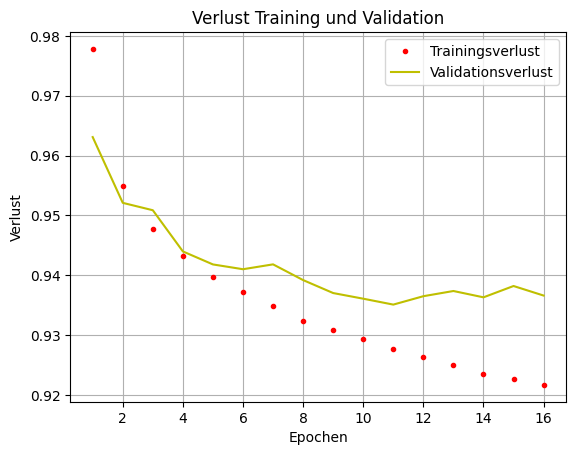

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r.', label='Trainingsverlust')
plt.plot(epochs, val_loss, 'y', label='Validationsverlust')
plt.title('Verlust Training und Validation')
plt.xlabel('Epochen')
plt.ylabel('Verlust')
plt.grid()
plt.legend()
plt.savefig('./Metriken/Verlust_1DCNN.png', dpi=300, bbox_inches='tight')
plt.show()

#### ▶️ Ausgabe der Genauigkeit für Training und Validation
***

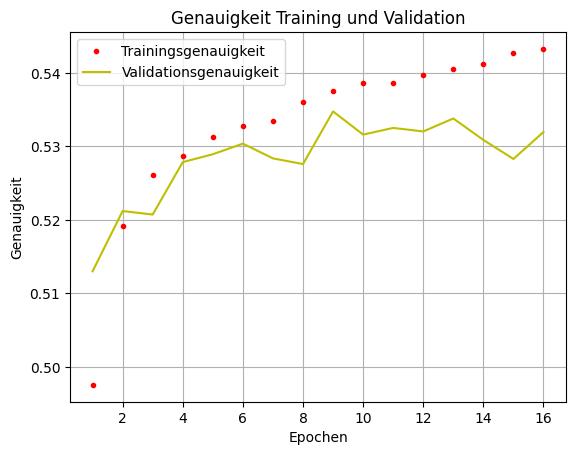

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'r.', label='Trainingsgenauigkeit')
plt.plot(epochs, val_acc, 'y', label='Validationsgenauigkeit')
plt.title('Genauigkeit Training und Validation')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.grid()
plt.legend()
plt.savefig('./Metriken/Genauigkeit_1DCNN.png', dpi=300, bbox_inches='tight')
plt.show()

#### ▶️ Modell auf Testdaten anwenden und evaluieren
***

In [13]:
score = model.evaluate(X_val, y_val, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.9365994334220886
Test accuracy: 0.5319547057151794


#### ▶️ Metriken zur Beurteilung der Modellqualität 
***

1377/1377 [==============================] - 2s 1ms/step


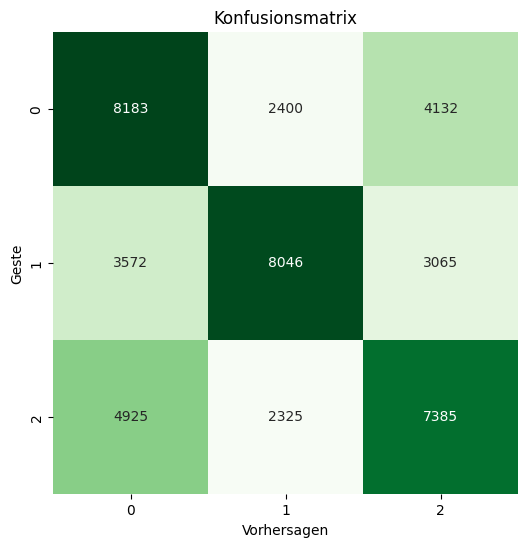

              precision    recall  f1-score   support

           0       0.49      0.56      0.52     14715
           1       0.63      0.55      0.59     14683
           2       0.51      0.50      0.51     14635

    accuracy                           0.54     44033
   macro avg       0.54      0.54      0.54     44033
weighted avg       0.54      0.54      0.54     44033



In [14]:
y_test_arg=np.argmax(y_test,axis=1)
y_pred = np.argmax(model.predict(X_test),axis=1)
 
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', cbar=False)
plt.xlabel("Vorhersagen")
plt.ylabel("Geste")
plt.title("Konfusionsmatrix")
plt.show()

print(classification_report(y_test_arg, y_pred))